## Imports

In [43]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


## Load Data

In [44]:
# Define the path to the CSV file
data_path = os.path.join(os.getcwd(), '..', '..', 'data', 'preprocessed_data_v2.csv')

# Load the dataset
df = pd.read_csv(data_path)

In [45]:
# mendefinisi kolom yang memprediksi (xcol) dan diprediksi (ycol) 
ycol = df['average_daily_rate'] 
xcol = df[['stay_duration_in_days', 
'booking_window', 
'distance_to_coastline', 
'lat',
'review_sentiment_score', 
'lng', 
'rating']]

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(xcol, ycol, test_size=0.2, random_state=42)

## RandomForestRegressor dengan Grid Search


In [48]:
from sklearn.model_selection import GridSearchCV

# Definisikan model
rf_regressor_tuned = RandomForestRegressor(random_state=42)

# Definisikan grid parameter
param_grid = {
    'n_estimators': [90, 100, 110],
    'max_features': [1, 2, 3],
    'max_depth' : [10,20,30],
    'min_samples_split' : [2,3,4],
    'min_samples_leaf' : [1,2,3],
}

# Atur Grid Search
grid_search_rf = GridSearchCV(estimator=rf_regressor_tuned, 
                              param_grid=param_grid, 
                              scoring='neg_mean_absolute_error', 
                              cv=5, 
                              verbose=2, 
                              n_jobs=-1)

# Fit Grid Search
grid_search_rf.fit(x_train, y_train)

# Dapatkan parameter terbaik dan skor terbaik
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print(f'Parameter Terbaik: {best_params_rf}')
print(f'Error Mutlak Rata-rata Terbaik: {-best_score_rf}')


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Parameter Terbaik: {'max_depth': 30, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 110}
Error Mutlak Rata-rata Terbaik: 18802.51519227691


In [51]:
# menggunakan RandomForestRegressor dengan parameter terbaik
rf_regressor = RandomForestRegressor(
    max_depth=30,
    max_features=3,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=110,
    bootstrap=False,
    n_jobs=-1
)

# train model
rf_regressor.fit(x_train, y_train)

# prediksi di test set
y_pred_train = rf_regressor.predict(x_train)
y_pred_test = rf_regressor.predict(x_test)

In [52]:
from sklearn.metrics import mean_absolute_error

# Evaluate the model using MAE
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f'Training MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

Training MAE: 9601.80150705749
Test MAE: 14714.347209742846


## Cross Validation


In [53]:
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score

# Define your RandomForestRegressor model
rf_regressor_cv = RandomForestRegressor(
    n_estimators=110,
    random_state=42,
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=2,
    bootstrap=False,
    n_jobs=-1
)

# Define the k-fold cross-validation scheme
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring function
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Perform cross-validation and get scores
cv_scores = cross_val_score(rf_regressor_cv, x_train, y_train, cv=kf, scoring=scorer)

# Convert negative MAE to positive since we used greater_is_better=False
cv_scores = -cv_scores

# Print the cross-validation scores and their mean
print(f'Cross-Validation MAE Scores: {cv_scores}')
print(f'Mean Cross-Validation MAE: {np.mean(cv_scores)}')

# Fit the model on the entire training data
rf_regressor_cv.fit(x_train, y_train)

# Make predictions on the test data
y_pred_test_cv = rf_regressor_cv.predict(x_test)

# Evaluate the model on the test data
testing_mae_cv = mean_absolute_error(y_test, y_pred_test_cv)
print(f'Mean Absolute Error on Testing: {testing_mae_cv}')


Cross-Validation MAE Scores: [16246.54701148 15636.27514048 16828.47557112 16414.45079462
 14993.33056827]
Mean Cross-Validation MAE: 16023.81581719402
Mean Absolute Error on Testing: 14776.827032090567


## Tampilkan variabel-variabel penting

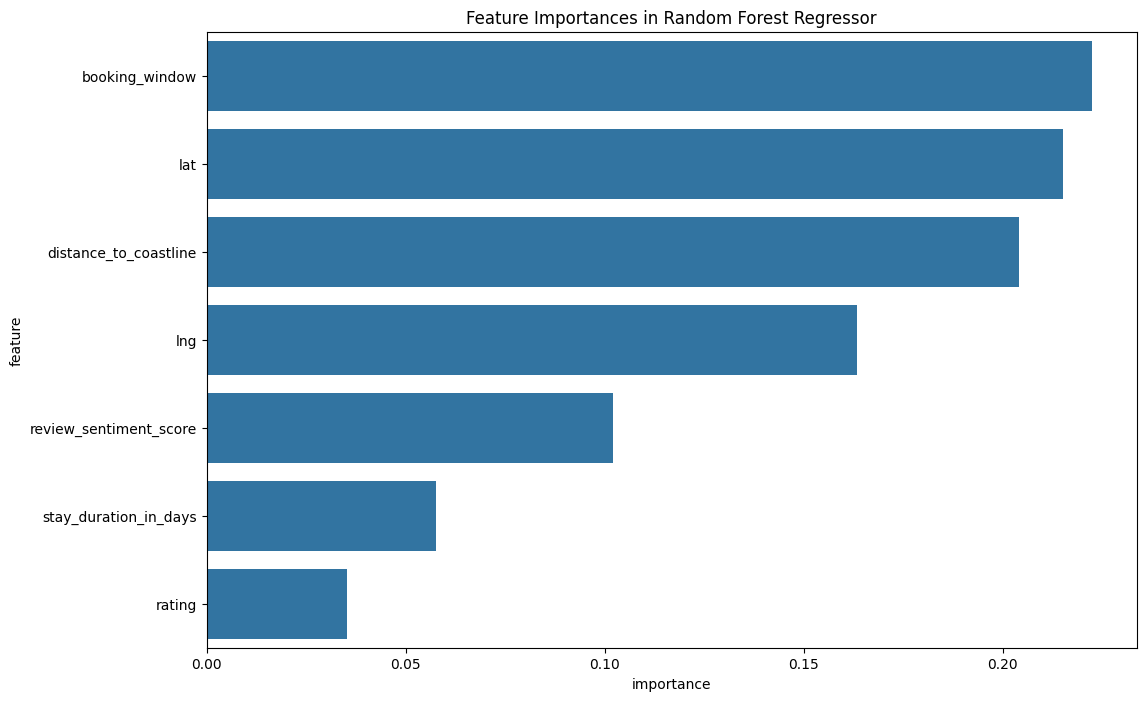

In [54]:
# Get feature importances
feature_importances = rf_regressor.feature_importances_

# Create a DataFrame for visualization
feature_importances_df = pd.DataFrame({
    'feature': xcol.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances_df)
plt.title('Feature Importances in Random Forest Regressor')
plt.show()